In [1]:
from openai import OpenAI

client = OpenAI()
audio_file = open("Stretch 3.mp3", "rb")

transcription = client.audio.transcriptions.create(
  file=audio_file,
  model="whisper-1",
  response_format="verbose_json",
  timestamp_granularities=["word"]
)

print(transcription.words)

[TranscriptionWord(end=2.4200000762939453, start=0.0, word='I'), TranscriptionWord(end=4.179999828338623, start=2.4200000762939453, word="don't"), TranscriptionWord(end=5.679999828338623, start=4.179999828338623, word='know'), TranscriptionWord(end=7.480000019073486, start=5.679999828338623, word='whether'), TranscriptionWord(end=8.960000038146973, start=7.480000019073486, word='or'), TranscriptionWord(end=9.279999732971191, start=8.960000038146973, word='not'), TranscriptionWord(end=10.520000457763672, start=9.279999732971191, word='this'), TranscriptionWord(end=10.779999732971191, start=10.520000457763672, word='is'), TranscriptionWord(end=10.899999618530273, start=10.779999732971191, word='gonna'), TranscriptionWord(end=11.220000267028809, start=10.899999618530273, word='work')]


In [2]:
import pandas as pd

transcription = client.audio.transcriptions.create(
    file=audio_file,
    model="whisper-1",
    response_format="verbose_json",
    timestamp_granularities=["word"]
  )

  # Convert to DataFrame
df = pd.DataFrame([{
      'word': word.word,
      'start': word.start,
      'end': word.end
  } for word in transcription.words])

print(df)


      word  start    end
0        I   0.00   2.42
1    don't   2.42   4.18
2     know   4.18   5.68
3  whether   5.68   7.48
4       or   7.48   8.96
5      not   8.96   9.28
6     this   9.28  10.52
7       is  10.52  10.78
8    gonna  10.78  10.90
9     work  10.90  11.22


In [9]:
df['Duration'] = df['end'] - df['start']

In [10]:
df

,word,start,end,Duration
0,I,0.00,2.42,2.420000
1,don't,2.42,4.18,1.760000
2,know,4.18,5.68,1.500000
3,whether,5.68,7.48,1.800000
4,or,7.48,8.96,1.480000
5,not,8.96,9.28,0.320000
6,this,9.28,10.52,1.240001
7,is,10.52,10.78,0.259999
8,gonna,10.78,10.90,0.120000
9,work,10.90,11.22,0.320001


In [3]:
# Option 1: Analyze timestamp gaps/overlaps
print("=== TIMESTAMP GAP ANALYSIS ===")
df['Gap_to_Next'] = df['start'].shift(-1) - df['end']
df['Overlap_with_Next'] = df['end'] - df['start'].shift(-1)

print("Gaps between words (seconds):")
print(df[['word', 'end', 'Gap_to_Next']].dropna())

print(f"\nSummary:")
print(f"- Zero gaps: {(df['Gap_to_Next'] == 0).sum()}")
print(f"- Negative gaps (overlaps): {(df['Gap_to_Next'] < 0).sum()}")
print(f"- Positive gaps: {(df['Gap_to_Next'] > 0).sum()}")

=== TIMESTAMP GAP ANALYSIS ===
Gaps between words (seconds):
      word    end  Gap_to_Next
0        I   2.42          0.0
1    don't   4.18          0.0
2     know   5.68          0.0
3  whether   7.48          0.0
4       or   8.96          0.0
5      not   9.28          0.0
6     this  10.52          0.0
7       is  10.78          0.0
8    gonna  10.90          0.0

Summary:
- Zero gaps: 9
- Negative gaps (overlaps): 0
- Positive gaps: 0


In [5]:
# Option 2: Add realistic gaps between words
import numpy as np

def add_realistic_gaps(df, gap_ratio=0.15):
    """Add realistic gaps between words by shrinking word durations"""
    df_fixed = df.copy()
    
    for i in range(len(df_fixed)):
        # Shrink each word by gap_ratio to create space
        word_duration = df_fixed.loc[i, 'Duration']
        actual_word_duration = word_duration * (1 - gap_ratio)
        
        # Update end time to create gap
        df_fixed.loc[i, 'end'] = df_fixed.loc[i, 'start'] + actual_word_duration
        
        # Update next word's start time (except for last word)
        if i < len(df_fixed) - 1:
            gap_size = word_duration * gap_ratio
            df_fixed.loc[i+1, 'start'] = df_fixed.loc[i, 'end'] + gap_size
    
    # Recalculate durations
    df_fixed['Duration'] = df_fixed['end'] - df_fixed['start']
    return df_fixed

print("=== OPTION 2: ADD REALISTIC GAPS ===")
df_with_gaps = add_realistic_gaps(df, gap_ratio=0.15)
print("Original vs Fixed:")
comparison = pd.DataFrame({
    'Word': df['word'],
    'Orig_Start': df['start'],
    'Orig_End': df['end'], 
    'Fixed_Start': df_with_gaps['start'],
    'Fixed_End': df_with_gaps['end'],
    'Gap_Added': df_with_gaps['start'].shift(-1) - df_with_gaps['end']
})
print(comparison.round(3))

=== OPTION 2: ADD REALISTIC GAPS ===


KeyError: 'Duration'

In [6]:
# Option 3: Audio-based word boundary detection
def detect_audio_boundaries(audio_file, words_df):
    """Use audio analysis to find more accurate word boundaries"""
    try:
        import librosa
        
        # Load audio
        y, sr = librosa.load(audio_file, sr=22050)
        
        # Calculate energy and spectral features
        frame_length = 2048
        hop_length = 512
        
        # RMS energy
        rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
        
        # Spectral centroid (brightness)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)[0]
        
        # Convert frame indices to time
        times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_length)
        
        print(f"Audio length: {len(y)/sr:.2f}s")
        print(f"RMS energy shape: {rms.shape}")
        print(f"Time frames: {len(times)}")
        
        # Find low-energy regions that could be gaps
        energy_threshold = np.percentile(rms, 25)  # Bottom 25% of energy
        low_energy_mask = rms < energy_threshold
        
        print(f"Low energy threshold: {energy_threshold:.4f}")
        print(f"Low energy frames: {low_energy_mask.sum()}/{len(rms)}")
        
        return {
            'times': times,
            'rms': rms,
            'spectral_centroid': spectral_centroid,
            'low_energy_mask': low_energy_mask,
            'energy_threshold': energy_threshold
        }
        
    except ImportError:
        print("librosa not available for audio analysis")
        return None
    except Exception as e:
        print(f"Audio analysis failed: {e}")
        return None

print("=== OPTION 3: AUDIO-BASED BOUNDARY DETECTION ===")
audio_analysis = detect_audio_boundaries("Stretch 3.mp3", df)
if audio_analysis:
    print("✅ Audio analysis completed successfully")
else:
    print("❌ Audio analysis not available")

=== OPTION 3: AUDIO-BASED BOUNDARY DETECTION ===
Audio length: 11.94s
RMS energy shape: (515,)
Time frames: 515
Low energy threshold: 0.0038
Low energy frames: 129/515
✅ Audio analysis completed successfully


In [7]:
# Option 4: Compare with ForceAlign timestamps
def test_forcealign_timestamps():
    """Compare Whisper-1 with ForceAlign for more accurate timing"""
    try:
        from forcealign_transcriber import transcribe_with_forcealign_timestamps
        
        print("🔄 Getting ForceAlign timestamps...")
        forcealign_words = transcribe_with_forcealign_timestamps("Stretch 3.mp3")
        
        if forcealign_words:
            fa_df = pd.DataFrame(forcealign_words)
            fa_df['Duration'] = fa_df['end'] - fa_df['start']
            fa_df['Gap_to_Next'] = fa_df['start'].shift(-1) - fa_df['end']
            
            print("ForceAlign Results:")
            print(fa_df[['word', 'start', 'end', 'Duration', 'Gap_to_Next']].round(3))
            
            print(f"\nForceAlign Gap Analysis:")
            print(f"- Zero gaps: {(fa_df['Gap_to_Next'] == 0).sum()}")
            print(f"- Negative gaps: {(fa_df['Gap_to_Next'] < 0).sum()}")
            print(f"- Positive gaps: {(fa_df['Gap_to_Next'] > 0).sum()}")
            print(f"- Average gap: {fa_df['Gap_to_Next'].dropna().mean():.3f}s")
            
            return fa_df
        else:
            print("❌ ForceAlign returned no words")
            return None
            
    except Exception as e:
        print(f"❌ ForceAlign test failed: {e}")
        return None

print("=== OPTION 4: FORCEALIGN COMPARISON ===")
forcealign_df = test_forcealign_timestamps()

=== OPTION 4: FORCEALIGN COMPARISON ===
🔄 Getting ForceAlign timestamps...
🔄 Generating transcript with ForceAlign's built-in ASR...


c:\Users\gensh\OneDrive\Máy tính\Lucy ver24\CHUNKS\Working on\SBF - V1 - test\SBF-V1\audio-analyzer\venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


No transcript provided. Generating transcript using speech_to_text...
Generated Transcript: AY NO NO WHETHER OR NOT THIS GUN O WORK
ForceAlign Results:
      word   start     end  Duration  Gap_to_Next
0       AY   0.000   2.584     2.584        0.020
1       NO   2.604   2.644     0.040        2.323
2       NO   4.967   5.668     0.701        1.383
3  WHETHER   7.051   7.912     0.861        0.921
4       OR   8.833   8.913     0.080        0.041
5      NOT   8.954   9.214     0.260        1.061
6     THIS  10.275  10.576     0.301        0.140
7      GUN  10.716  10.856     0.140        0.040
8        O  10.896  10.976     0.080        0.041
9     WORK  11.017  11.237     0.220          NaN

ForceAlign Gap Analysis:
- Zero gaps: 0
- Negative gaps: 0
- Positive gaps: 9
- Average gap: 0.663s


=== OPTION 5: TIMING VISUALIZATION ===
Plotting failed: 'Duration'


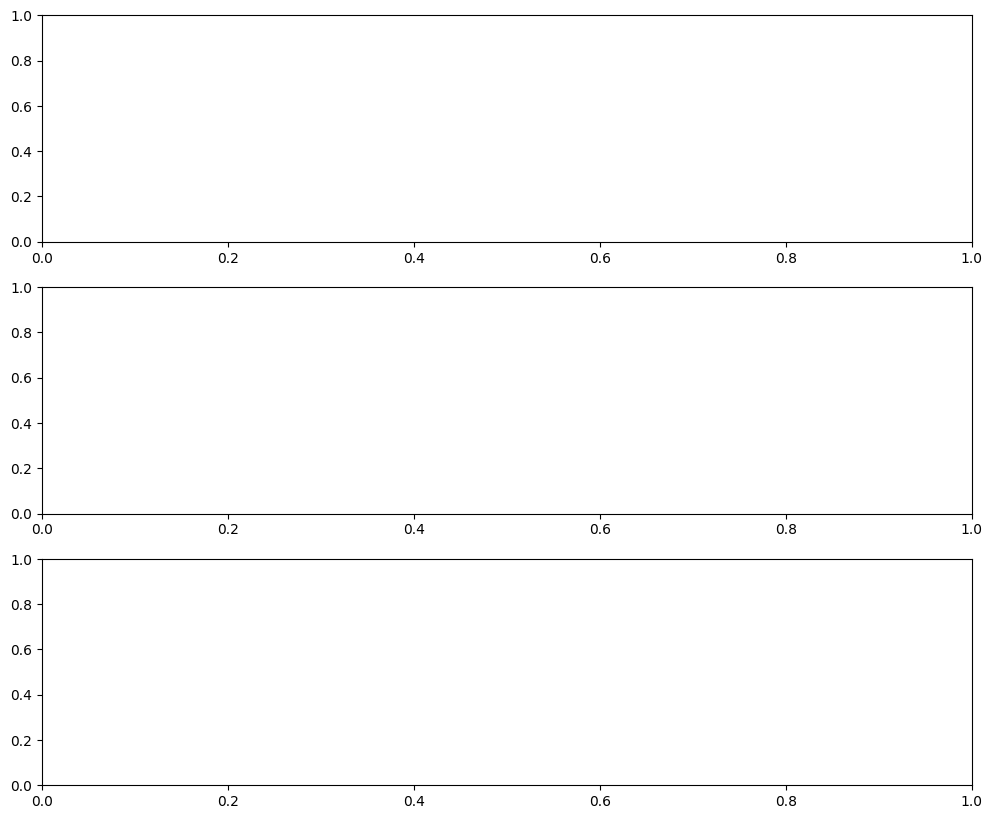

In [8]:
# Option 5: Visualize timing issues
def plot_timing_comparison():
    """Create visualization of timing issues and solutions"""
    try:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(3, 1, figsize=(12, 10))
        
        # Plot 1: Original Whisper-1 timestamps (continuous)
        ax1 = axes[0]
        for i, row in df.iterrows():
            ax1.barh(0, row['Duration'], left=row['start'], height=0.3, 
                    alpha=0.7, label=f"{row['word']}")
            ax1.text(row['start'] + row['Duration']/2, 0, row['word'], 
                    ha='center', va='center', fontsize=8)
        ax1.set_title("Original Whisper-1: Continuous Timestamps (No Gaps)")
        ax1.set_ylabel("Words")
        ax1.set_xlim(0, 12)
        
        # Plot 2: Fixed timestamps with gaps
        ax2 = axes[1]
        if 'df_with_gaps' in locals():
            for i, row in df_with_gaps.iterrows():
                ax2.barh(0, row['Duration'], left=row['start'], height=0.3, 
                        alpha=0.7, color='green')
                ax2.text(row['start'] + row['Duration']/2, 0, row['word'], 
                        ha='center', va='center', fontsize=8)
        ax2.set_title("Fixed: Added Realistic Gaps Between Words")
        ax2.set_ylabel("Words")
        ax2.set_xlim(0, 12)
        
        # Plot 3: Audio energy overlay
        ax3 = axes[2]
        if audio_analysis:
            times = audio_analysis['times']
            rms = audio_analysis['rms']
            ax3.plot(times, rms, alpha=0.7, label='RMS Energy')
            ax3.axhline(y=audio_analysis['energy_threshold'], color='red', 
                       linestyle='--', label='Low Energy Threshold')
            ax3.fill_between(times, 0, rms, where=audio_analysis['low_energy_mask'], 
                           alpha=0.3, color='red', label='Potential Gaps')
        ax3.set_title("Audio Energy Analysis: Potential Gap Locations")
        ax3.set_xlabel("Time (seconds)")
        ax3.set_ylabel("Energy")
        ax3.legend()
        ax3.set_xlim(0, 12)
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("matplotlib not available for plotting")
    except Exception as e:
        print(f"Plotting failed: {e}")

print("=== OPTION 5: TIMING VISUALIZATION ===")
plot_timing_comparison()

In [ ]:
pip install openai-whisper
whisper audio.wav --model large-v2 --language en --word_timestamps True

=== OPTION 6: CORRECTED STRETCH ANALYSIS ===
Stretch Analysis Comparison:

1. ORIGINAL (Whisper-1 continuous timestamps):


ModuleNotFoundError: No module named 'pyphen'

In [10]:
!pip install openai-whisper

  Using cached openai_whisper-20250625-py3-none-any.whl
  Using cached tiktoken-0.11.0-cp313-cp313-win_amd64.whl.metadata (6.9 kB)
Using cached tiktoken-0.11.0-cp313-cp313-win_amd64.whl (883 kB)

   ---------------------------------------- 0/2 [tiktoken]
   -------------------- ------------------- 1/2 [openai-whisper]
   -------------------- ------------------- 1/2 [openai-whisper]
   -------------------- ------------------- 1/2 [openai-whisper]
   -------------------- ------------------- 1/2 [openai-whisper]
   ---------------------------------------- 2/2 [openai-whisper]




  0%|                                              | 0.00/2.87G [00:00<?, ?iB/s]
  0%|                                      | 672k/2.87G [00:00<07:46, 6.62MiB/s]
  0%|                                     | 2.33M/2.87G [00:00<04:02, 12.7MiB/s]
  0%|                                     | 5.61M/2.87G [00:00<02:17, 22.4MiB/s]
  0%|                                     | 9.44M/2.87G [00:00<01:47, 28.5MiB/s]
  0%|▏                                    | 12.3M/2.87G [00:00<01:53, 27.0MiB/s]
  1%|▏                                    | 16.7M/2.87G [00:00<01:33, 33.0MiB/s]
  1%|▎                                    | 21.9M/2.87G [00:00<01:17, 39.4MiB/s]
  1%|▎                                    | 26.1M/2.87G [00:00<01:16, 40.3MiB/s]
  1%|▍                                    | 29.9M/2.87G [00:00<01:21, 37.7MiB/s]
  1%|▍                                    | 33.6M/2.87G [00:01<01:22, 37.0MiB/s]
  1%|▍                                    | 38.1M/2.87G [00:01<01:16, 39.6MiB/s]
  1%|▌                     

In [15]:
import whisper

model = whisper.load_model("large-v2")
result = model.transcribe("audio.wav", word_timestamps=True, language="en")
print(result['segments'])

c:\Users\gensh\OneDrive\Máy tính\Lucy ver24\CHUNKS\Working on\SBF - V1 - test\SBF-V1\audio-analyzer\venv\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


[{'id': 0, 'seek': 0, 'start': np.float64(0.0), 'end': np.float64(11.2), 'text': " I don't know whether or not this is gonna work", 'tokens': [50364, 286, 500, 380, 458, 1968, 420, 406, 341, 307, 799, 589, 51016], 'temperature': 0.0, 'avg_logprob': -0.32606349672589985, 'compression_ratio': 0.8846153846153846, 'no_speech_prob': 0.12006931751966476, 'words': [{'word': ' I', 'start': np.float64(0.0), 'end': np.float64(2.06), 'probability': np.float64(0.8072343468666077)}, {'word': " don't", 'start': np.float64(2.06), 'end': np.float64(4.26), 'probability': np.float64(0.8389975428581238)}, {'word': ' know', 'start': np.float64(4.26), 'end': np.float64(5.66), 'probability': np.float64(0.8013659119606018)}, {'word': ' whether', 'start': np.float64(5.66), 'end': np.float64(7.42), 'probability': np.float64(0.7842622399330139)}, {'word': ' or', 'start': np.float64(7.42), 'end': np.float64(8.88), 'probability': np.float64(0.8790137767791748)}, {'word': ' not', 'start': np.float64(8.88), 'end': 

In [16]:
print(result)

{'text': " I don't know whether or not this is gonna work", 'segments': [{'id': 0, 'seek': 0, 'start': np.float64(0.0), 'end': np.float64(11.2), 'text': " I don't know whether or not this is gonna work", 'tokens': [50364, 286, 500, 380, 458, 1968, 420, 406, 341, 307, 799, 589, 51016], 'temperature': 0.0, 'avg_logprob': -0.32606349672589985, 'compression_ratio': 0.8846153846153846, 'no_speech_prob': 0.12006931751966476, 'words': [{'word': ' I', 'start': np.float64(0.0), 'end': np.float64(2.06), 'probability': np.float64(0.8072343468666077)}, {'word': " don't", 'start': np.float64(2.06), 'end': np.float64(4.26), 'probability': np.float64(0.8389975428581238)}, {'word': ' know', 'start': np.float64(4.26), 'end': np.float64(5.66), 'probability': np.float64(0.8013659119606018)}, {'word': ' whether', 'start': np.float64(5.66), 'end': np.float64(7.42), 'probability': np.float64(0.7842622399330139)}, {'word': ' or', 'start': np.float64(7.42), 'end': np.float64(8.88), 'probability': np.float64(0

In [17]:
!pip install nemo-toolkit[all]

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached sentencepiece-0.2.1-cp313-cp313-win_amd64.whl.metadata (10 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependen

  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      + C:\Users\gensh\OneDrive\Máy tính\Lucy ver24\CHUNKS\Working on\SBF - V1 - test\SBF-V1\audio-analyzer\venv\Scripts\python.exe C:\Users\gensh\AppData\Local\Temp\pip-install-yyx0m4bb\numpy_e3a93e59836a4270a2ba5702e4d57b9f\vendored-meson\meson\meson.py setup C:\Users\gensh\AppData\Local\Temp\pip-install-yyx0m4bb\numpy_e3a93e59836a4270a2ba5702e4d57b9f C:\Users\gensh\AppData\Local\Temp\pip-install-yyx0m4bb\numpy_e3a93e59836a4270a2ba5702e4d57b9f\.mesonpy-e2ckcsp8 -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\gensh\AppData\Local\Temp\pip-install-yyx0m4bb\numpy_e3a93e59836a4270a2ba5702e4d57b9f\.mesonpy-e2ckcsp8\meson-python-native-file.ini
      The Meson build system
      Version: 1.2.99
      Source dir: C:\Users\gensh\AppData\Local\Temp\pip-install-yyx0m4bb\numpy_e3a93e59836a4270a2ba5702e4d57b9f
      Bu

In [18]:
from nemo.collections.asr.models import EncDecCTCModel
from nemo.tools.nemo_forced_aligner import alignment

ModuleNotFoundError: No module named 'nemo'

In [ ]:
aligner = alignment.NeMoForcedAligner()
result = aligner.align(
      audio_file="Stretch 3.mp3",
      transcript="I don't know whether or not this is gonna work"      
  )

In [ ]:
for word in result.words:
      print(f"{word.text}: {word.start:.3f}s - {word.end:.3f}s")